## Feature Engineering

In [116]:
import pandas as pd
import featuretools as ft

In [117]:
df_anp = pd.read_pickle('../../data/Visual_well_being/anp.pickle')
df_celeb = pd.read_pickle('../../data/Visual_well_being/celebrity.pickle')
df_face = pd.read_pickle('../../data/Visual_well_being/face.pickle')
df_img_data = pd.read_pickle('../../data/Visual_well_being/image_data.pickle')
df_img_metrics = pd.read_pickle('../../data/Visual_well_being/image_metrics.pickle')
df_object = pd.read_pickle('../../data/Visual_well_being/object_labels.pickle')
df_survey = pd.read_pickle('../../data/Visual_well_being/survey.pickle')

In [118]:
import sys
lib_dir = "../../libs/"
if lib_dir not in sys.path:
    sys.path.append(lib_dir)

In [119]:
import image_level_agg_features as img_f
import user_level_agg_features as usr_f

In [120]:
# Create new entityset
es = ft.EntitySet(id = 'users')

In [121]:
df_survey.head()

,index,id,gender,born,education,employed,income,A_2,N_1,P_1,...,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account
0,0,920bf027f7d13dbdc7b66b3d3324903c,Male,1975,College graduate,Employed for wages,"$30,000 to $39,999",4,5,5,...,4.333333,4.000000,4.666667,5.000000,3.666667,4.2500,4.000000,4.333333,465.0,public
1,1,b433b2bfe49e28d0b7c45925b53084e0,Male,1978,College graduate,Employed for wages,"$20,000 to $29,999",8,0,9,...,9.000000,7.333333,9.000000,8.000000,7.666667,8.2500,0.000000,9.000000,6.0,public
2,4,f4f54676f75f47c17dc434cf68845328,Female,1990,High school graduate,Employed for wages,"$80,000 to $89,999",7,3,8,...,8.000000,7.333333,7.666667,7.666667,7.333333,7.5625,3.333333,8.000000,767.0,public
3,5,a27a5fc47a59f35761705330253a58e3,Male,1997,High school graduate,Employed for wages,"$20,000 to $29,999",7,5,7,...,6.000000,4.666667,3.666667,6.666667,5.666667,5.3750,6.000000,6.000000,43.0,public
4,6,0a1002b2232a4ecbde604462f6d84bf9,Female,1993,College graduate,A student,"$20,000 to $29,999",7,5,7,...,5.666667,6.000000,6.000000,6.666667,7.000000,NaN,3.000000,5.666667,73.0,public


In [128]:
df_survey = df_survey.drop_duplicates('insta_user_id')

In [129]:
df_img_data['image_posted_time'] = pd.to_datetime(df_img_data['image_posted_time'])

In [130]:
df_img_data['user_id'] = pd.to_numeric(df_img_data['user_id'])
df_survey['insta_user_id'] = pd.to_numeric(df_survey['insta_user_id'])

In [131]:
df_img_data_metrics = pd.merge(df_img_data, df_img_metrics, on='image_id')

In [132]:
#Create two FT entities

es = es.entity_from_dataframe(entity_id = 'users', dataframe = df_survey, 
                              index = 'insta_user_id')

es = es.entity_from_dataframe(entity_id = 'image_data_metrics', dataframe = df_img_data_metrics, make_index=True, 
                              variable_types = {'user_bio': ft.variable_types.Text, 'user_website': ft.variable_types.Text}, index='data_metric_id', time_index='comment_count_time_created')

In [133]:
# Relationship between users and images
r_user_img_data_metrics = ft.Relationship(es['users']['insta_user_id'],
                                    es['image_data_metrics']['user_id'])


# Add the relationship to the entity set
es = es.add_relationship(r_user_img_data_metrics)

In [ ]:
# Create new features using specified primitives
features, feature_names = ft.dfs(entityset = es, target_entity = 'users', 
                                 agg_primitives = ['mean', 'max', 'percent_true', 'last', 'num_unique', 'min'],
                                 trans_primitives = ['years', 'month', 'subtract', 'divide'])

In [134]:
# Perform deep feature synthesis without specifying primitives
features, feature_names = ft.dfs(entityset=es, target_entity='users', 
                                 max_depth = 2)

features.head()

,index,born,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,...,MODE(image_data_metrics.DAY(like_count_time_created)),MODE(image_data_metrics.YEAR(image_posted_time)),MODE(image_data_metrics.YEAR(comment_count_time_created)),MODE(image_data_metrics.YEAR(like_count_time_created)),MODE(image_data_metrics.MONTH(image_posted_time)),MODE(image_data_metrics.MONTH(comment_count_time_created)),MODE(image_data_metrics.MONTH(like_count_time_created)),MODE(image_data_metrics.WEEKDAY(image_posted_time)),MODE(image_data_metrics.WEEKDAY(comment_count_time_created)),MODE(image_data_metrics.WEEKDAY(like_count_time_created))
insta_user_id,,,,,,,,,,,,,,,,,,,,,
1619510,44,1974,6,2,4,7,4,3,5,4,...,19.0,2012.0,2017.0,2017.0,4.0,6.0,6.0,6.0,0.0,0.0
2829661,114,1980,8,6,8,8,7,8,7,7,...,19.0,2011.0,2017.0,2017.0,5.0,6.0,6.0,6.0,0.0,0.0
3069744,117,1995,5,8,7,8,7,5,5,7,...,19.0,2013.0,2017.0,2017.0,10.0,6.0,6.0,6.0,0.0,0.0
3988856,10,1979,7,8,10,10,9,8,8,10,...,19.0,2013.0,2017.0,2017.0,5.0,6.0,6.0,2.0,0.0,0.0
4185084,63,1987,7,8,6,6,8,10,5,9,...,19.0,2015.0,2017.0,2017.0,7.0,6.0,6.0,6.0,0.0,0.0


In [144]:
features.corr()

,index,born,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,...,MODE(image_data_metrics.DAY(like_count_time_created)),MODE(image_data_metrics.YEAR(image_posted_time)),MODE(image_data_metrics.YEAR(comment_count_time_created)),MODE(image_data_metrics.YEAR(like_count_time_created)),MODE(image_data_metrics.MONTH(image_posted_time)),MODE(image_data_metrics.MONTH(comment_count_time_created)),MODE(image_data_metrics.MONTH(like_count_time_created)),MODE(image_data_metrics.WEEKDAY(image_posted_time)),MODE(image_data_metrics.WEEKDAY(comment_count_time_created)),MODE(image_data_metrics.WEEKDAY(like_count_time_created))
index,1.000000,0.188326,-0.062583,0.146987,-0.047745,0.100396,0.093268,-0.000603,0.152312,-0.079917,...,0.440987,0.164029,NaN,NaN,-0.063150,NaN,NaN,-0.089027,0.440987,0.440987
born,0.188326,1.000000,-0.051263,-0.069792,0.037664,-0.231500,0.021378,0.069176,0.075473,-0.037104,...,0.090034,0.063055,NaN,NaN,0.111293,NaN,NaN,-0.012899,0.090034,0.090034
A_2,-0.062583,-0.051263,1.000000,-0.301719,0.405381,0.425511,0.529295,0.386854,0.432016,0.364787,...,-0.131579,0.018316,NaN,NaN,-0.023475,NaN,NaN,-0.004469,-0.131579,-0.131579
N_1,0.146987,-0.069792,-0.301719,1.000000,-0.258729,0.053951,-0.345149,-0.364693,-0.233466,-0.259033,...,0.058697,-0.117026,NaN,NaN,-0.067322,NaN,NaN,0.090132,0.058697,0.058697
P_1,-0.047745,0.037664,0.405381,-0.258729,1.000000,0.271250,0.553898,0.404173,0.524564,0.294557,...,-0.000773,-0.014719,NaN,NaN,0.066283,NaN,NaN,-0.021691,-0.000773,-0.000773
E_1,0.100396,-0.231500,0.425511,0.053951,0.271250,1.000000,0.415718,0.180565,0.264887,0.193895,...,0.047267,-0.076652,NaN,NaN,-0.061108,NaN,NaN,-0.074864,0.047267,0.047267
A_1,0.093268,0.021378,0.529295,-0.345149,0.553898,0.415718,1.000000,0.511799,0.571168,0.299810,...,-0.033361,0.049762,NaN,NaN,0.001931,NaN,NaN,-0.109325,-0.033361,-0.033361
H_1,-0.000603,0.069176,0.386854,-0.364693,0.404173,0.180565,0.511799,1.000000,0.438715,0.345311,...,-0.038311,0.051172,NaN,NaN,0.043954,NaN,NaN,0.074368,-0.038311,-0.038311
M_1,0.152312,0.075473,0.432016,-0.233466,0.524564,0.264887,0.571168,0.438715,1.000000,0.342506,...,0.099697,0.015311,NaN,NaN,0.109379,NaN,NaN,-0.052046,0.099697,0.099697
R_1,-0.079917,-0.037104,0.364787,-0.259033,0.294557,0.193895,0.299810,0.345311,0.342506,1.000000,...,-0.099499,-0.053602,NaN,NaN,-0.083259,NaN,NaN,0.009047,-0.099499,-0.099499


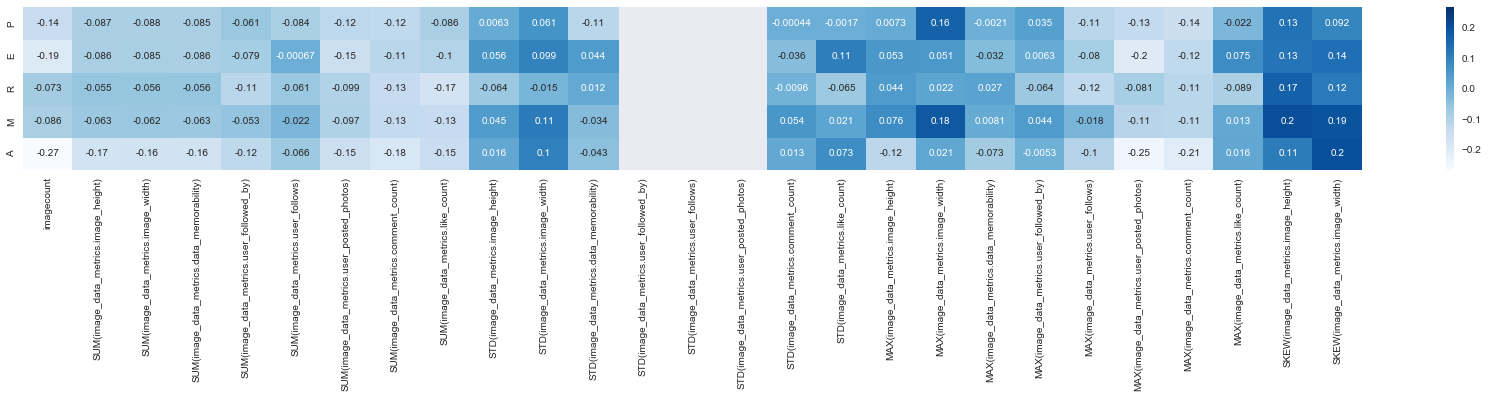

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(30,3))

sns.heatmap(features.corr().loc[['P', 'E', 'R', 'M', 'A'], :].iloc[:,33:60], cmap='Blues', annot=True)

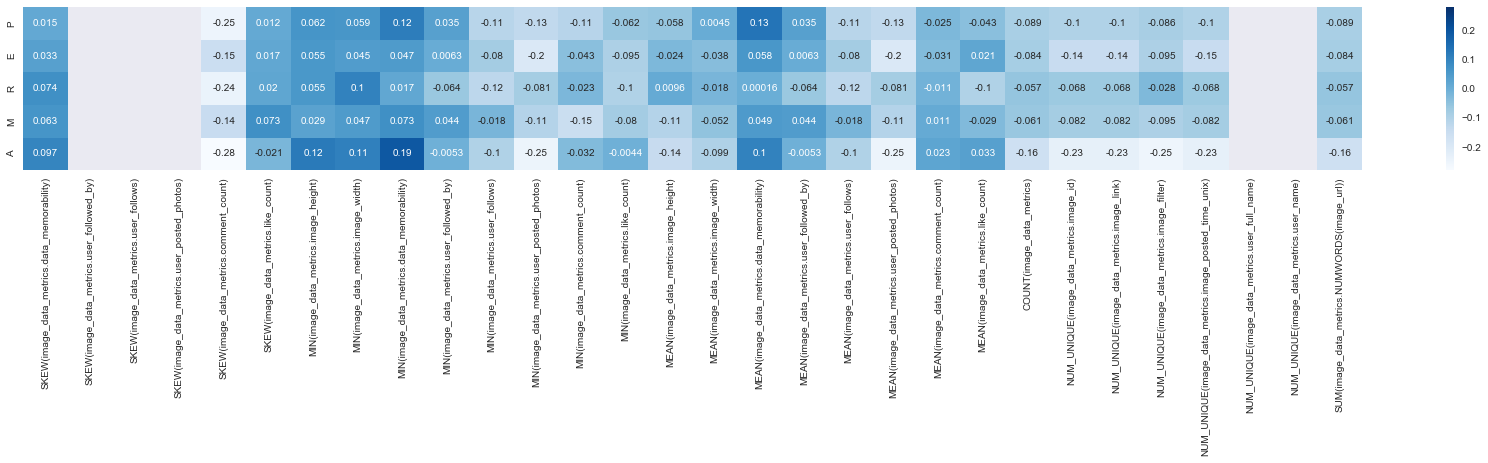

In [160]:
plt.figure(figsize=(30,3))

sns.heatmap(features.corr().loc[['P', 'E', 'R', 'M', 'A'], :].iloc[:,60:90], cmap='Blues', annot=True)

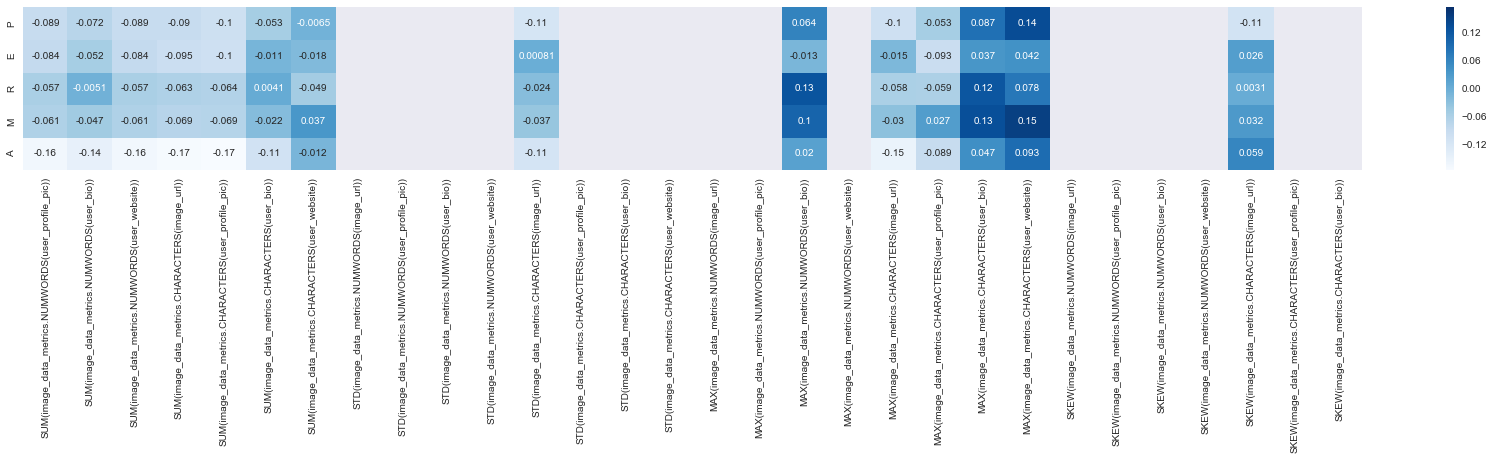

In [161]:
plt.figure(figsize=(30,3))

sns.heatmap(features.corr().loc[['P', 'E', 'R', 'M', 'A'], :].iloc[:,90:120], cmap='Blues', annot=True)

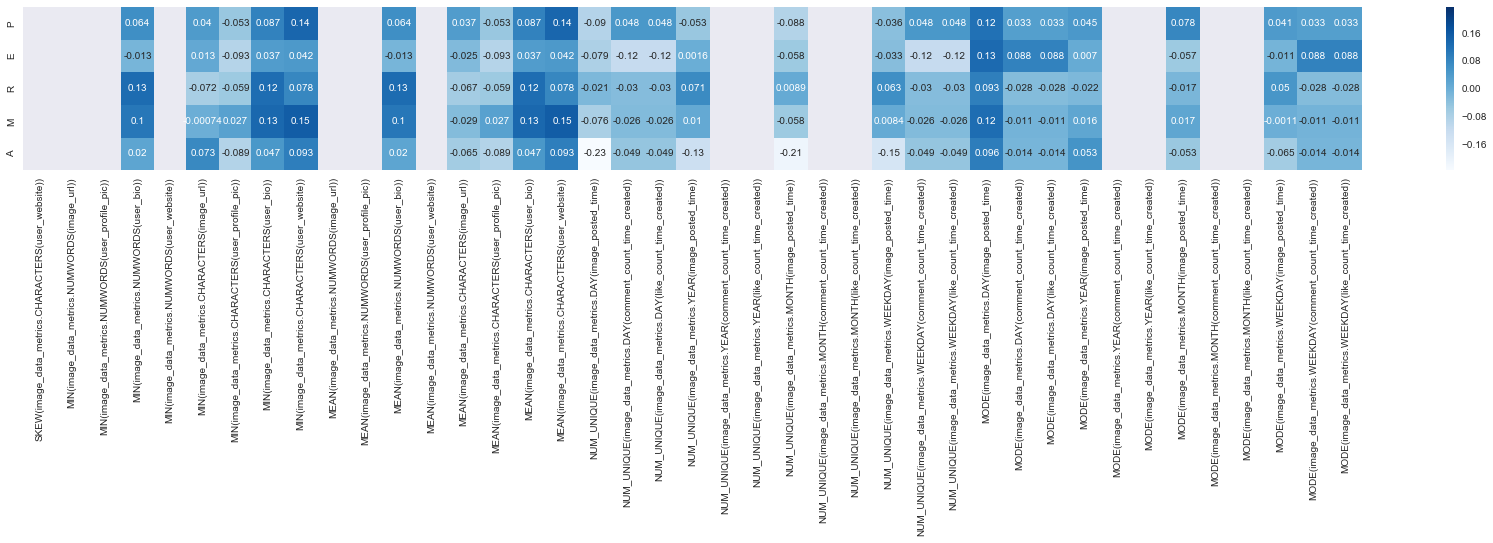

In [162]:
plt.figure(figsize=(30,3))

sns.heatmap(features.corr().loc[['P', 'E', 'R', 'M', 'A'], :].iloc[:,120:], cmap='Blues', annot=True)

In [171]:
df_significant_corr = features.corr().loc[['P', 'E', 'R', 'M', 'A'], :]

df_significant_corr = df_significant_corr.dropna(axis=1).drop('index', axis=1)

In [172]:
df_significant_corr.head()

,born,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,M_2,...,NUM_UNIQUE(image_data_metrics.WEEKDAY(comment_count_time_created)),NUM_UNIQUE(image_data_metrics.WEEKDAY(like_count_time_created)),MODE(image_data_metrics.DAY(image_posted_time)),MODE(image_data_metrics.DAY(comment_count_time_created)),MODE(image_data_metrics.DAY(like_count_time_created)),MODE(image_data_metrics.YEAR(image_posted_time)),MODE(image_data_metrics.MONTH(image_posted_time)),MODE(image_data_metrics.WEEKDAY(image_posted_time)),MODE(image_data_metrics.WEEKDAY(comment_count_time_created)),MODE(image_data_metrics.WEEKDAY(like_count_time_created))
P,-0.018254,0.533825,-0.392402,0.826550,0.328506,0.654888,0.554829,0.622172,0.479530,0.670222,...,0.047526,0.047526,0.115535,0.032635,0.032635,0.045269,0.077729,0.041436,0.032635,0.032635
E,-0.170813,0.440351,0.005809,0.411142,0.745084,0.510883,0.239954,0.358698,0.290590,0.501671,...,-0.115364,-0.115364,0.128702,0.087569,0.087569,0.007023,-0.057226,-0.011069,0.087569,0.087569
R,-0.082017,0.460298,-0.345365,0.515247,0.266796,0.479671,0.505283,0.515937,0.796757,0.694270,...,-0.030077,-0.030077,0.092606,-0.027544,-0.027544,-0.021909,-0.017220,0.050156,-0.027544,-0.027544
M,-0.024026,0.541149,-0.347948,0.554419,0.370310,0.729839,0.545329,0.820106,0.458410,0.869759,...,-0.026216,-0.026216,0.124095,-0.010926,-0.010926,0.016480,0.016992,-0.001112,-0.010926,-0.010926
A,-0.025269,0.806803,-0.363273,0.546319,0.501199,0.830228,0.536880,0.574566,0.387155,0.639161,...,-0.048851,-0.048851,0.095514,-0.013823,-0.013823,0.053440,-0.053361,-0.064836,-0.013823,-0.013823


In [178]:
df_significant_corr = df_significant_corr.loc[:, 'P':].drop(['PERMA', 'N_EMO', 'P_EMO'], axis=1)

In [181]:
df_data_p = features.loc[:, df_significant_corr.columns].drop(['E', 'R', 'M', 'A'], axis=1)

In [182]:
df_data_p.head()

,P,imagecount,SUM(image_data_metrics.image_height),SUM(image_data_metrics.image_width),SUM(image_data_metrics.data_memorability),SUM(image_data_metrics.user_followed_by),SUM(image_data_metrics.user_follows),SUM(image_data_metrics.user_posted_photos),SUM(image_data_metrics.comment_count),SUM(image_data_metrics.like_count),...,NUM_UNIQUE(image_data_metrics.WEEKDAY(comment_count_time_created)),NUM_UNIQUE(image_data_metrics.WEEKDAY(like_count_time_created)),MODE(image_data_metrics.DAY(image_posted_time)),MODE(image_data_metrics.DAY(comment_count_time_created)),MODE(image_data_metrics.DAY(like_count_time_created)),MODE(image_data_metrics.YEAR(image_posted_time)),MODE(image_data_metrics.MONTH(image_posted_time)),MODE(image_data_metrics.WEEKDAY(image_posted_time)),MODE(image_data_metrics.WEEKDAY(comment_count_time_created)),MODE(image_data_metrics.WEEKDAY(like_count_time_created))
insta_user_id,,,,,,,,,,,,,,,,,,,,,
1619510,3.000000,1515.0,950266.0,953636.0,1220.343579,556556.0,1244606.0,3114573.0,1183.0,10278.0,...,1.0,1.0,4.0,19.0,19.0,2012.0,4.0,6.0,0.0,0.0
2829661,7.666667,123.0,203260.0,201096.0,249.012550,63756.0,92736.0,39928.0,120.0,2299.0,...,1.0,1.0,28.0,19.0,19.0,2011.0,5.0,6.0,0.0,0.0
3069744,4.666667,350.0,211612.0,212332.0,283.515559,106051.0,81840.0,119350.0,745.0,4600.0,...,1.0,1.0,2.0,19.0,19.0,2013.0,10.0,6.0,0.0,0.0
3988856,10.000000,609.0,378994.0,379136.0,512.292704,445788.0,574287.0,371490.0,780.0,6074.0,...,1.0,1.0,6.0,19.0,19.0,2013.0,5.0,2.0,0.0,0.0
4185084,6.333333,64.0,22703.0,23956.0,28.091945,912.0,2470.0,2432.0,30.0,208.0,...,1.0,1.0,31.0,19.0,19.0,2015.0,7.0,6.0,0.0,0.0


In [192]:
df_data_p = df_data_p.dropna()

In [198]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [194]:

x_train, x_test, y_train, y_test = train_test_split(df_data_p.drop('P', axis=1), df_data_p.P, test_size=0.3)

In [195]:
model = GradientBoostingRegressor()

In [196]:
model.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [197]:
pred = model.predict(x_test)

In [200]:
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)

In [201]:
print(mse)

4.76459516485


In [202]:
print(mae)

1.77543601747


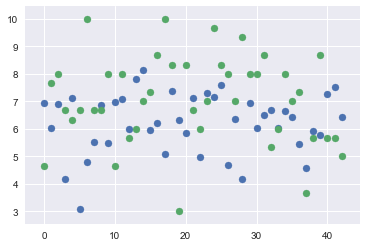

In [205]:
plt.scatter(range(0, len(pred)), pred)
plt.scatter(range(0, len(y_test)), y_test)

In [206]:
features.P.describe()

count    159.000000
mean       6.693920
std        1.688868
min        1.666667
25%        5.666667
50%        6.666667
75%        8.000000
max       10.000000
Name: P, dtype: float64